# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:
Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


<div style="background-color:#e6f4ff; padding: 15px; border-radius: 8px;">
    
**Александр,**
    
Приношу искренние извинения, я внимательно прочитала все ваши правки, однако в процессе работы случайно загрузила предыдущую версию ноутбука, из-за чего обновлённый файл с вашими замечаниями был перезаписан.
 
Тем не менее я полностью запомнила все ваши рекомендации, а именно:
- добавить овервью проекта: цели и задачи исследования;
- вынести параметры подключения в `.env` и считывать их через `dotenv`, вместо явного указания в коде;
- доработать графики (подписать оси, добавить понятные заголовки);
- расширить и уточнить блок с итоговыми рекомендациями для бизнеса.
    
Все эти изменения я повторно внесла в текущую версию проекта. К самому выполнению заданий и выводам из них никаких серьезных замечаний не было


<div style="background-color:#e6f4ff; padding: 15px; border-radius: 8px;">
Добавила цель и задачи исследования

### Цель исследования

Целью исследования является анализ поведения пользователей после первой покупки и выявление факторов, влияющих на возврат клиентов.

Основная задача - определить, какие характеристики первого заказа и профиля пользователя связаны с более высоким уровнем повторных покупок и общей лояльностью, чтобы предложить бизнесу обоснованные рекомендации по увеличению удержания.

### Задачи исследования

Для достижения цели были поставлены следующие задачи:

- Провести подготовку и очистку данных:

    - преобразовать даты и валюту,

    - создать профиль пользователя,

    - удалить экстремальные значения по ключевым метрикам.

- Описать структуру и качество данных:

    - проанализировать распределения заказов, билетов и интервалов между покупками,
    
    - выявить возможные выбросы и сезонные особенности.

- Изучить характеристики первого заказа и их влияние на возврат пользователей:

    - тип мероприятия, регион, устройство, билетный оператор и др.

- Проанализировать связь поведения пользователей с ключевыми метриками:

    - средняя выручка,

    - количество билетов в заказе,

    - временные интервалы между заказами.

- Провести сегментацию пользователей по количеству заказов (1, 2–4, 5+ заказов) и оценить различия между ними.

- Выполнить корреляционный анализ значимых признаков для поиска факторов, связанных с высокой лояльностью пользователей.

- Сформировать выводы и рекомендации для бизнеса с учётом выявленных закономерностей.

In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import os
from dotenv import load_dotenv

<div style="background-color:#e6f4ff; padding: 15px; border-radius: 8px;">
Загрузила файл .env в директорию и подгрузила параметры подключения с него

In [4]:
load_dotenv(dotenv_path="./credentials.env")

True

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'), 
    os.getenv('DB_PASSWORD'), 
    os.getenv('DB_HOST'), 
    os.getenv('DB_PORT'), 
    os.getenv('DB_NAME') )

In [6]:
engine=create_engine(connection_string)

In [7]:
query='''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true))
SELECT p.user_id, 
        p.device_type_canonical, 
        p.order_id, 
        p.created_dt_msk AS order_dt, 
        p.created_ts_msk AS order_ts, 
        p.currency_code, 
        p.revenue, 
        p.tickets_count, 
        p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER ( PARTITION BY p.user_id ORDER BY p.created_dt_msk ) AS days_since_prev, 
        p.event_id, 
        p.service_name,
        e.event_type_main,
        r.region_name,
        c.city_name 
FROM afisha.purchases AS p 
JOIN afisha.events AS e 
ON p.event_id = e.event_id 
JOIN afisha.city AS c 
ON e.city_id = c.city_id 
JOIN afisha.regions AS r 
ON c.region_id = r.region_id 
WHERE p.device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм' 
ORDER BY p.user_id'''

In [8]:
df=pd.read_sql_query(query, con=engine)

In [9]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

- В выгрузке у меня получился датафрейм из 14 колонок и 290610 строк. 

- На первый взгляд все типы данных указаны корректно (можно попытаться понизить размерность некоторых колонок, например,tickets_count с int64 до int8). 

- В данных пропущенные значения есть только в колонке days_since_prev (возможно где-то есть и значения-заглушки, и дальше я это проверю, но явные пропущенные занчения присутствуют только в этой колонке), что ожидаемо, так как у покупателя может не быть повторной покупки и в этом случае значение в этой колонке будет NULL

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [11]:
df_tenge=pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [12]:
#Вывожу первые 5 строк, чтобы посмотреть как выглядит таблица
df_tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Так как при присоединении таблиц важно учитывать типы данных (в моем случае колонка data обязательно должна быть датой), то я проверяю таблицу с помощью info()

In [13]:
df_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Так как колонка data представлена типом object, а мне это не подходит, я меняю тип на datetime, указывая явный формат

In [14]:
df_tenge['data']=pd.to_datetime(df_tenge['data'], format='%Y-%m-%d')

Мне было бы удобнее видеть сколько рублей стоит 1 тенге вместо сколько рублей стоит 100 тенге, поэтому я создаю дополнительную колонку

In [15]:
df_tenge['curs_1_tenge']=df_tenge['curs']/100

In [16]:
df_tenge.head()

,data,nominal,curs,cdx,curs_1_tenge
0,2024-01-10,100,19.9391,kzt,0.199391
1,2024-01-11,100,19.7255,kzt,0.197255
2,2024-01-12,100,19.5839,kzt,0.195839
3,2024-01-13,100,19.4501,kzt,0.194501
4,2024-01-14,100,19.4501,kzt,0.194501


Теперь, когда у меня есть курс по каждой дате в нужно типе данных, я могу соединить 2 таблицы. В таблице df_tenge я буду использовать колонку data для соединения, а в основной таблице df - order_dt. Тип присоединения будет left, где слева будет основная таблица, так как мне важно ничего не потерять оттуда при соединении

In [17]:
df_merged=df.merge(df_tenge[['curs_1_tenge','data']], left_on='order_dt', right_on='data', how='left')

In [18]:
df_merged.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,curs_1_tenge,data
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск,0.186972,2024-08-20
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск,0.183419,2024-07-23
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск,0.196475,2024-10-06
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск,0.185010,2024-07-13
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк,0.196648,2024-10-04


Проверяю, что все строки основной таблицы остались в том же количестве. Можно заметить, что в колонке curs_1_tenge нет пропущенных значений после присоединения, значит таблица df_tenge охвытывает весь временной интервал основной таблицы df 

In [19]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

Следующий этап - это написать код, который будет преобразовывать revenue и переводить выручку в рубли (при условии, что currency_code='kzt'), если же нет, то оставлять выручку как естью Для этого буду использовать библиотеку numpy и функцию этой библиотеки np.where, так как это самый быстрый и простой способ выполнить задачу

In [20]:
df_merged['revenue_rub']=np.where(df_merged['currency_code']=='kzt',
                                      df_merged['revenue']*df_merged['curs_1_tenge'],
                                      df_merged['revenue'])

In [21]:
#проверяю, что все правильно перевелось
df_merged[df_merged['currency_code']=='kzt']

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,curs_1_tenge,data,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,Билеты без проблем,другое,Верхоречная область,Серебрянка,0.190125,2024-09-17,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,Билеты без проблем,другое,Верхоречная область,Серебрянка,0.189330,2024-09-02,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,Билеты без проблем,другое,Верхоречная область,Серебрянка,0.185991,2024-09-09,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,Мой билет,концерты,Верхоречная область,Серебрянка,0.198928,2024-06-11,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,Мой билет,концерты,Шанырский регион,Широковка,0.199833,2024-06-04,1478.296591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290484,ffc24188a1d58f2,mobile,6862648,2024-07-11,2024-07-11 12:39:48,kzt,4735.52,2,20.0,538828,Билеты без проблем,концерты,Верхоречная область,Серебрянка,0.182738,2024-07-11,865.359454
290485,ffc24188a1d58f2,mobile,6763294,2024-09-05,2024-09-05 12:07:00,kzt,4735.52,2,56.0,538828,Билеты без проблем,концерты,Верхоречная область,Серебрянка,0.184217,2024-09-05,872.363288
290486,ffc24188a1d58f2,mobile,3984021,2024-09-06,2024-09-06 19:20:03,kzt,1849.41,1,1.0,533803,Мой билет,концерты,Шанырский регион,Широковка,0.185504,2024-09-06,343.072953
290488,ffc4133fbba20f4,mobile,8493869,2024-06-21,2024-06-21 14:04:34,kzt,3698.83,2,NaN,533803,Мой билет,концерты,Шанырский регион,Широковка,0.185791,2024-06-21,687.209325


In [22]:
#удаляю колонку с выручкой, оставляя только колонку с выручкой в рублях, а также колонки с курсом и датой курса, т.к. они больше не нужны
df_merged=df_merged.drop(columns=['revenue','curs_1_tenge','data'],axis=1)

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [23]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   tickets_count          290611 non-null  int64         
 7   days_since_prev        268678 non-null  float64       
 8   event_id               290611 non-null  int64         
 9   service_name           290611 non-null  object        
 10  event_type_main        290611 non-null  object        
 11  region_name            290611 non-null  object        
 12  city_name              290611 non-null  obje

Для начала снижаю размерность числовых колонок 

In [24]:
df_merged['tickets_count']=pd.to_numeric(df_merged['tickets_count'], downcast='integer')

In [25]:
df_merged['days_since_prev']=pd.to_numeric(df_merged['days_since_prev'], downcast='float')

In [26]:
df_merged['revenue_rub']=pd.to_numeric(df_merged['revenue_rub'], downcast='float')

Проверяю, что все корректно применилось

In [27]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   tickets_count          290611 non-null  int8          
 7   days_since_prev        268678 non-null  float32       
 8   event_id               290611 non-null  int64         
 9   service_name           290611 non-null  object        
 10  event_type_main        290611 non-null  object        
 11  region_name            290611 non-null  object        
 12  city_name              290611 non-null  obje

Далее проверяю колонки с датой и временем. Поля order_dt и order_ts содержат корректные типы данных datetime64.
Диапазон дат с 06.06.2024 по 31.10.2024 соответствует ожидаемому периоду выгрузки.
В данных 153 уникальных даты, что полностью совпадает с календарным диапазоном, пропущенных дней нет. Ошибок в датах не обнаружено.

In [28]:
df_merged.groupby('order_dt', as_index=False).agg({'order_id':'count'})

,order_dt,order_id
0,2024-06-01,1102
1,2024-06-02,925
2,2024-06-03,1222
3,2024-06-04,1252
4,2024-06-05,1219
...,...,...
148,2024-10-27,2866
149,2024-10-28,2860
150,2024-10-29,2889
151,2024-10-30,2960


Проверяю распределение покупок билетов по датам

<div style="background-color:#e6f4ff; padding: 15px; border-radius: 8px;">
Дополнила график подписями осей и заголовком

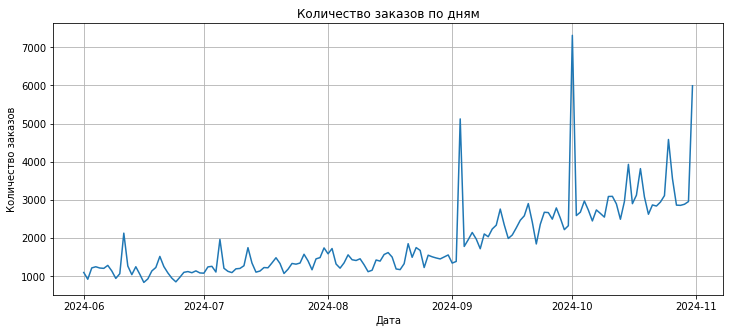

In [29]:
df_merged.groupby(df_merged['order_dt'].dt.date).size().plot(figsize=(12, 5))
plt.title("Количество заказов по дням")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.grid(True)
plt.show()

При анализе распределения заказов по дням выявлены несколько пиковых дат (5000-7000 заказов). Данные аномалии не выглядят ошибочными, так как сохраняется корректный диапазон дат и времени, а резкие увеличения могут быть связаны с сезонностью, акциями или маркетинговыми активностями. Мне интересно посмотреть на топ-10 дней по активности покупок

In [30]:
daily=df_merged.groupby(df_merged['order_dt'].dt.date).size()

Эти значения выглядят реалистичными, так как приходятся на даты, типичные для роста активности:
- начало месяца,
- конец месяца,
- сезонный спрос (сентябрь/октябрь),
- вероятные маркетинговые акции.

In [31]:
daily.sort_values(ascending=False).head(10)

order_dt
2024-10-01    7313
2024-10-31    5992
2024-09-03    5124
2024-10-25    4585
2024-10-15    3934
2024-10-18    3822
2024-10-26    3558
2024-10-17    3126
2024-10-24    3115
2024-10-11    3096
dtype: int64

Теперь перехожу к колонке с временем. Для начала я хочу проверить соответствие между order_dt и order_ts. В результате вижу, что даты в колонках нигде не расходятся

In [32]:
(df_merged['order_dt'] == df_merged['order_ts'].dt.date).value_counts()

True    290611
dtype: int64

Затем проверяю какие занчения часов есть, чтобы убедится что в данных нет ошибок, а заодно проверяю распределние покупок билетов по часам.

In [33]:
df_merged['order_ts'].dt.hour.value_counts().sort_index()

0      5336
1      2765
2      1450
3      1055
4      1381
5      1814
6      3127
7      5274
8      9964
9     12525
10    15817
11    28738
12    20397
13    18403
14    18261
15    17927
16    17117
17    17188
18    16778
19    17010
20    16303
21    16700
22    15281
23    10000
Name: order_ts, dtype: int64

В распределении заказов по часам также не выявлено ничего подозрительного. Рост начинается с 7:00, пик с 11:00 до 15:00, где объёмы стабильно высокие (20-28 тысяч), после 17:00 начинается плавный спад, но активность остаётся высокой до 22:00, ночные часы (0:00-6:00) предсказуемо самые слабые

<div style="background-color:#e6f4ff; padding: 15px; border-radius: 8px;">
Дополнила график подписями осей и заголовком

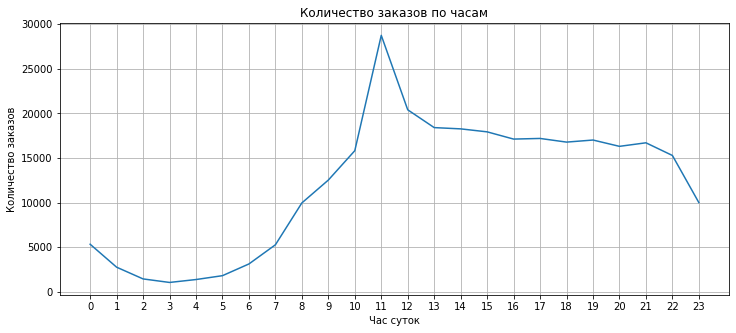

In [34]:
df_merged.groupby(df_merged['order_ts'].dt.hour).size().plot(figsize=(12, 5))
plt.title("Количество заказов по часам")
plt.xlabel("Час суток")
plt.ylabel("Количество заказов")
plt.grid(True)
plt.xticks(range(0, 24), rotation=0)
plt.show()

Проверяю данные по устройствам, у нас, как и ожидалось, 2 типа устройства

In [35]:
df_merged['device_type_canonical'].value_counts()

mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64

Далее перехожу к названиям операторов. Для начала привожу всё в одному регистру и удаляю лишние пробелы

In [36]:
df_merged['service_name']=df_merged['service_name'].str.strip().str.lower()

Не вижу неявных дубликатов в данных. Самые высокие продажи у операторов билеты без проблем, билеты в руки и лови билет!

In [37]:
df_merged['service_name'].value_counts().sort_index()

crazy ticket!               790
show_ticket                2200
билет по телефону            85
билеты без проблем        63519
билеты в интернете            4
билеты в руки             40343
быстробилет                2003
быстрый кассир              381
весь в билетах            16849
восьмёрка                  1118
вперёд!                      80
выступления.ру             1616
городской дом культуры     2733
дом культуры               4502
дырокол                      74
за билетом!                2865
зе бест!                      5
карандашру                  133
кино билет                   67
край билетов               6207
лимоны                        8
лови билет!               41124
лучшие билеты             17774
мир касс                   2167
мой билет                 34839
облачко                   26642
прачечная                 10273
радио ticket                376
реестр                      125
росбилет                    539
тебе билет!                5228
телебиле

Проверяю навзания типа мероприятия, а также распределние покупок по типам. Самые популярные это концерты(околоко 40% всех заказов), театр (23%) и другое (22%).

In [38]:
df_merged['event_type_main'].value_counts(normalize=True)

концерты    0.396668
театр       0.231653
другое      0.226650
спорт       0.075396
стендап     0.046086
выставки    0.016703
ёлки        0.006844
Name: event_type_main, dtype: float64

Перехожу к изучению числовых колонок, начинаю с изучения статистических показателей для tickets_count. Стандартная покупка включает 2-4 билета (медиана = 3), среднее 2.75; редкие покупки с большим количеством билетов (до 57) создают выбросы.

In [39]:
df_merged['tickets_count'].describe()

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Далее изучаю статистические показатели для revenue_rub.

По предоставленным данным по столбцу revenue_rub можно сделать следующий вывод: распределение выручки сильно смещено вправо, так как среднее значение (556) значительно выше медианы (351). Наблюдаются как отрицательные значения (минус 91), так и высокие пики (75-й перцентиль 802), что указывает на наличие выбросов и сильную вариативность данных (стандартное отклонение 875). В целом, большинство наблюдений сосредоточено в диапазоне от 114 до 802 рублей, но есть как очень низкие, так и аномально высокие значения.

In [40]:
df_merged['revenue_rub'].describe()

count    290611.000000
mean        555.572083
std         875.498169
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

Проверяю отрицательные значения в выручке и вижу, что большинство покупок (83%) приходится на тип мероприятия "другое"

In [41]:
df_merged[df_merged['revenue_rub']<0].groupby('event_type_main', as_index=False).agg(orders=('order_id','count'))

,event_type_main,orders
0,выставки,43
1,другое,315
2,концерты,1
3,спорт,22


Так как по условию задания данные нужно отфильтровать по 99 перцентилю, а затем в выводах отразить количество удаленных строк, то для начала я считаю количество строк в исходном датасете, применяю фильтрацию и считаю количество строк после фильтрации. Отрицательные значения выручки сохранены, так как в задании не сказано их удалять.

In [42]:
rows_before_filter=df_merged.shape[0]

In [43]:
df_merged=df_merged[df_merged['revenue_rub']<df_merged['revenue_rub'].quantile(0.99)]

In [44]:
rows_after_filter=df_merged.shape[0]

In [45]:
print(f'До фильрации по 99 перцентилю в датасете было {rows_before_filter} строк, после фильрации стало {rows_after_filter}.')
print(f'Всего удалено {rows_before_filter-rows_after_filter} ({1 - (rows_after_filter / rows_before_filter):.2%}).')

До фильрации по 99 перцентилю в датасете было 290611 строк, после фильрации стало 287604.
Всего удалено 3007 (1.03%).


После фильтрации визуализирую распредение выручки с помощью гистограммы. Вижу распределение с длинным хвостом с правой стороны из-за наличия выбросов

In [46]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

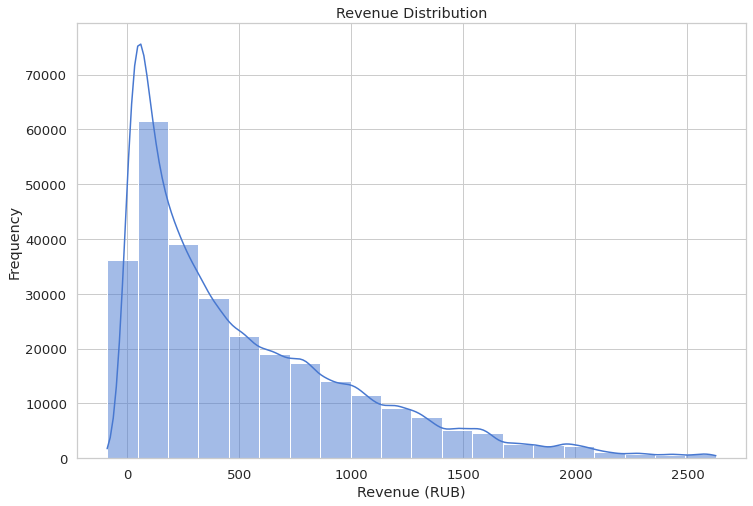

In [47]:
plt.figure(figsize=(12, 8))
sns.histplot(df_merged['revenue_rub'], kde=True, bins=20, edgecolor="white")
plt.title("Revenue Distribution")
plt.xlabel("Revenue (RUB)")
plt.ylabel("Frequency")
plt.show()

Явных дубликатов в данных нет

In [48]:
df_merged.duplicated().sum()

0

По этому разделу можно сделать следующие выводы:

Анализ столбцов order_dt и order_ts показал, что оба содержат корректный тип данных datetime64[ns], ошибок чтения и преобразования форматов не выявлено.
Диапазон дат полностью соответствует ожидаемому периоду выгрузки: с 6 июня 2024 года по 31 октября 2024 года.

В данных присутствуют 153 уникальные даты, что совпадает с количеством календарных дней в указанном диапазоне.

Пропусков дат нет - каждый день содержит записи.

В данных отсутствуют некорректные временные метки.

Таким образом, диапазон дат является полноценным, корректным и непрерывным.

При анализе распределения заказов по дням выявлены несколько пиковых дат (5000-7000 заказов). Данные аномалии не выглядят ошибочными, так как сохраняется корректный диапазон дат и времени, а резкие увеличения могут быть связаны с сезонностью, днем зарплат(первые числа месяца), акциями или маркетинговыми активностями.

Что касается частотности заказов по часам:
- Рост начинается с 7:00

- Пик с 11:00 до 15:00, где объёмы стабильно высокие (20-28 тысяч)

- После 17:00 начинается плавный спад, но активность остаётся высокой до 22:00

- Ночные часы (0:00-6:00) предсказуемо самые слабые

Ничего необычного в распределении по часам нет. Профиль активности полностью соответствует стандартному пользовательскому поведению:
- пик в середине дня

Пользователи наиболее активны с позднего утра и до середины дня - это нормальный и очень типичный паттерн.
- стабильная вечерняя активность

После работы люди также совершают покупки, но меньше, чем днём.
- низкая активность ночью

0:00-6:00 всегда провал - это ожидаемо для B2C-сервисов.

По данным столбца tickets_count можно сделать следующие выводы: большинство покупок включает небольшое количество билетов, чаще всего от 2 до 4 (медиана = 3, 25-й и 75-й перцентили = 2 и 4). Среднее значение (2.75) близко к медиане, что говорит о относительно симметричном распределении для большинства наблюдений. При этом встречаются редкие экстремальные покупки с большим количеством билетов (максимум 57), что заметно увеличивает стандартное отклонение (1.17) и указывает на наличие выбросов. Минимальное значение равно 1, что соответствует покупке одного билета.

Среди записей с отрицательной выручкой большая часть (83%) относится к типу мероприятия "другое". То есть не вся выручка, а именно отрицательная часть сосредоточена в этом типе. Это может указывать на возвраты, корректировки или специфические операции, которые учитываются в категории "другое"

В столбцах с номинальными данными (названия устройств, типы мероприятий, операторы билетов и др.) ошибок, некорректных категорий или значений-заглушек не выявлено, данные выглядят чистыми и однородными.

В столбцах с числовыми данными, особенно в ключевых показателях revenue_rub и tickets_count, проведён анализ распределений и выявлены выбросы. Для revenue_rub применена фильтрация по 99 перцентилю, сохранив отрицательные значения, так как они отражают реальные операции возвратов и корректировок. Анализ количества билетов показал редкие экстремальные значения, которые не требовали удаления.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [49]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287604 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287604 non-null  object        
 1   device_type_canonical  287604 non-null  object        
 2   order_id               287604 non-null  int64         
 3   order_dt               287604 non-null  datetime64[ns]
 4   order_ts               287604 non-null  datetime64[ns]
 5   currency_code          287604 non-null  object        
 6   tickets_count          287604 non-null  int8          
 7   days_since_prev        265882 non-null  float32       
 8   event_id               287604 non-null  int64         
 9   service_name           287604 non-null  object        
 10  event_type_main        287604 non-null  object        
 11  region_name            287604 non-null  object        
 12  city_name              287604 non-null  obje

In [50]:
df_merged=df_merged.sort_values('order_ts')

In [51]:
df_merged['days_diff'] = df_merged.groupby('user_id')['order_dt'].diff().dt.days

In [52]:
user_profile = df_merged.groupby('user_id').agg(
    first_order=('order_dt', 'min'),
    last_order=('order_dt', 'max'),
    first_device=('device_type_canonical', 'first'),
    first_region_name=('region_name', 'first'),
    first_service_name=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    total_orders=('order_id', 'nunique'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between_orders=('days_diff', 'mean')
).reset_index()

In [53]:
user_profile.head(10)

,user_id,first_order,last_order,first_device,first_region_name,first_service_name,first_event_type,total_orders,avg_revenue,avg_tickets,avg_days_between_orders
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.000000
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,лови билет!,другое,3,767.213318,2.666667,51.000000
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.000000
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,лови билет!,концерты,13,1175.808472,3.307692,0.083333
6,00147c9209d45d3,2024-06-25,2024-06-25,mobile,Каменевский регион,облачко,концерты,2,352.945007,1.500000,0.000000
7,0018ecd8a38a51b,2024-07-25,2024-07-25,mobile,Медовская область,билеты без проблем,спорт,1,0.000000,3.000000,NaN
8,00199a573901564,2024-06-17,2024-06-17,mobile,Каменевский регион,билеты без проблем,концерты,1,588.119995,4.000000,NaN
9,001e7037d013f0f,2024-07-04,2024-09-29,mobile,Златопольский округ,мой билет,другое,3,326.623322,1.333333,43.500000


In [54]:
user_profile['is_two']=np.where(user_profile['total_orders']>=2,1,0)

In [55]:
user_profile['is_five']=np.where(user_profile['total_orders']>=5,1,0)

In [56]:
user_profile.head()

,user_id,first_order,last_order,first_device,first_region_name,first_service_name,first_event_type,total_orders,avg_revenue,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


В результате этого задания, я построила профиль пользователя и буду использовать этот датафрейм в дальнейших заданиях

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [57]:
total_users=user_profile.shape[0]

In [58]:
avg_revenue_per_order=user_profile['avg_revenue'].mean()

In [59]:
share_two_or_more = user_profile['is_two'].mean()

In [60]:
share_five_or_more = user_profile['is_five'].mean()

In [61]:
print(f"Общее число пользователей: {total_users}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб.")
print(f"Доля пользователей с 2 и более заказами: {share_two_or_more:.1%}")
print(f"Доля пользователей с 5 и более заказами: {share_five_or_more:.1%}")

Общее число пользователей: 21848
Средняя выручка с одного заказа: 543.39 руб.
Доля пользователей с 2 и более заказами: 61.7%
Доля пользователей с 5 и более заказами: 29.0%


In [62]:
stats = user_profile[['total_orders','avg_tickets','avg_days_between_orders']].describe()

In [63]:
print(stats)

       total_orders   avg_tickets  avg_days_between_orders
count  21848.000000  21848.000000             13483.000000
mean      13.163859      2.742918                15.880072
std      121.624128      0.913389                22.275459
min        1.000000      1.000000                 0.000000
25%        1.000000      2.000000                 1.000000
50%        2.000000      2.750000                 8.071429
75%        5.000000      3.076923                20.500000
max    10175.000000     11.000000               148.000000


По статистикам явно видны аномалии:

total_orders:

- Среднее 13, но медиана = 2, распределение сильно смещено вправо.

- Максимальное значение 10175 заказов - это явно выброс, далеко за пределами 75-го перцентиля (5 заказов).

- Стандартное отклонение 122 тоже говорит о сильной вариативности.

avg_tickets:

- Большинство пользователей покупают 2-3 билета за заказ, медиана 2.75.

- Максимум = 11 билетов - это редкий случай, тоже можно рассматривать как выброс.

avg_days_between_orders

- Среднее 16 дней, медиана 8 дней.

- Есть пользователи с экстремально большим интервалом до 148 дней, что тоже выбивается из общей картины.

- К тому же у 13483 пользователей есть данные, значит часть пользователей с 1 заказом не имеет интервала (NaN) и это нормально.

Для исключения экстремальных выбросов я решила применить фильтрацию по 99-му перцентилю для показателей total_orders, avg_tickets и avg_days_between_orders. После фильтрации я оставлю 99% пользователей, что позволит сохранить репрезентативность выборки и одновременно исключить редкие аномальные значения.

In [64]:
orders_99 = user_profile['total_orders'].quantile(0.99)

In [65]:
tickets_99 = user_profile['avg_tickets'].quantile(0.99)

In [66]:
days_99 = user_profile['avg_days_between_orders'].quantile(0.99)

In [67]:
filtered_users = user_profile[
    (user_profile['total_orders'] <= orders_99) &
    (user_profile['avg_tickets'] <= tickets_99) &
    (user_profile['avg_days_between_orders'] <= days_99)]

In [68]:
filtered_stats = filtered_users[['total_orders','avg_tickets','avg_days_between_orders']].describe()

In [69]:
filtered_count = filtered_users.shape[0]

In [70]:
total_count = user_profile.shape[0]

In [71]:
filtered_share = filtered_count / total_count

In [72]:
print(f"99-й перцентиль total_orders: {orders_99}")
print(f"99-й перцентиль avg_tickets: {tickets_99}")
print(f"99-й перцентиль avg_days_between_orders: {days_99}")
print(f"Объём данных после фильтрации: {filtered_count} пользователей ({filtered_share:.2%})")
print("\nСтатистика после фильтрации:")
print(filtered_stats)

99-й перцентиль total_orders: 152.0
99-й перцентиль avg_tickets: 5.0
99-й перцентиль avg_days_between_orders: 112.0
Объём данных после фильтрации: 13072 пользователей (59.83%)

Статистика после фильтрации:
       total_orders   avg_tickets  avg_days_between_orders
count  13072.000000  13072.000000             13072.000000
mean      10.076805      2.721216                15.058702
std       17.505051      0.691118                19.495774
min        2.000000      1.000000                 0.000000
25%        2.000000      2.300000                 1.333333
50%        4.000000      2.666667                 8.333333
75%        9.000000      3.057563                20.297619
max      152.000000      5.000000               112.000000


Судя по этой статистике после фильтрации:

total_orders: медиана  4, среднее 10, максимум 152 - выбросы сильно уменьшились по сравнению с исходным максимумом 10175, распределение стало более репрезентативным для типичных пользователей.

avg_tickets: медиана 2.67, среднее 2.72, максимум = 5 - редкие экстремальные значения исключены, показатели стали более стабильными.

avg_days_between_orders: медиана 8.33, среднее 15, максимум  112 - экстремальные интервалы тоже сокращены, что делает среднее значение более адекватным для анализа.

Вывод:
Фильтрация по 99-му перцентилю позволила убрать явно аномальные значения, сохранив большую часть пользователей (13 072 из исходных 21 848). Данные после фильтрации стали более стабильными и репрезентативными, что позволяет использовать их для дальнейшего анализа и построения выводов о поведении типичного пользователя.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [73]:
# 1. Распределение по типу первого мероприятия

In [74]:
event_dist = user_profile.groupby('first_event_type')['user_id'].count().reset_index(name='users')

In [75]:
event_dist['share'] = event_dist['users'] / event_dist['users'].sum()

In [76]:
event_dist = event_dist.sort_values('users', ascending=False)

In [77]:
print('Распределение по типу первого мероприятия:')
print(event_dist)

Распределение по типу первого мероприятия:
  first_event_type  users     share
2         концерты   9634  0.440956
1           другое   5491  0.251327
5            театр   4290  0.196357
4          стендап   1119  0.051218
3            спорт    801  0.036662
0         выставки    418  0.019132
6             ёлки     95  0.004348


In [78]:
# 2. Распределение по типу устройства первого заказа

In [79]:
device_dist = user_profile.groupby('first_device')['user_id'].count().reset_index(name='users')

In [80]:
device_dist['share'] = device_dist['users'] / device_dist['users'].sum()

In [81]:
device_dist = device_dist.sort_values('users', ascending=False)

In [82]:
print('Распределение по типу устройства:')
print(device_dist)

Распределение по типу устройства:
  first_device  users    share
1       mobile  18105  0.82868
0      desktop   3743  0.17132


In [83]:
# 3. Распределение по региону первого заказа

In [84]:
region_dist = user_profile.groupby('first_region_name')['user_id'].count().reset_index(name='users')

In [85]:
region_dist['share'] = region_dist['users'] / region_dist['users'].sum()

In [86]:
region_dist = region_dist.sort_values('users', ascending=False)

In [87]:
print('Распределение по региону:')
print(region_dist)

Распределение по региону:
           first_region_name  users     share
23        Каменевский регион   7161  0.327765
60      Североярская область   3801  0.173975
77       Широковская область   1237  0.056618
45          Озернинский край    678  0.031033
41      Малиновоярский округ    529  0.024213
..                       ...    ...       ...
17            Залесский край      2  0.000092
70       Тихогорская область      2  0.000092
5          Верхозёрский край      1  0.000046
66  Сосноводолинская область      1  0.000046
80        Яснопольский округ      1  0.000046

[81 rows x 3 columns]


In [88]:
# 4. Распределение по билетному оператору первого заказа

In [89]:
service_dist = user_profile.groupby('first_service_name')['user_id'].count().reset_index(name='users')

In [90]:
service_dist['share'] = service_dist['users'] / service_dist['users'].sum()

In [91]:
service_dist = service_dist.sort_values('users', ascending=False)

In [92]:
print('Распределение по билетному оператору:')
print(service_dist)

Распределение по билетному оператору:
        first_service_name  users     share
3       билеты без проблем   5223  0.239061
22               мой билет   2981  0.136443
19             лови билет!   2849  0.130401
4            билеты в руки   2595  0.118775
23                 облачко   2196  0.100513
7           весь в билетах   1304  0.059685
20           лучшие билеты   1188  0.054376
24               прачечная    588  0.026913
17            край билетов    459  0.021009
12            дом культуры    358  0.016386
33                  яблоко    320  0.014647
28             тебе билет!    311  0.014235
11  городской дом культуры    219  0.010024
21                мир касс    211  0.009658
13             за билетом!    203  0.009291
1              show_ticket    164  0.007506
5              быстробилет    162  0.007415
10          выступления.ру     96  0.004394
8                восьмёрка     86  0.003936
6           быстрый кассир     61  0.002792
0            crazy ticket!     45  0.0

Анализ распределения пользователей по признакам первого заказа показал выраженные «точки входа» на платформу:

- Тип первого мероприятия: почти половина пользователей (44%) сделали первый заказ на концерты, ещё 25% на категорию «другое», 20% на театр. Остальные категории (стендап, спорт, выставки, ёлки) встречаются значительно реже, каждая менее 6% пользователей.

- Регион проведения первого заказа: пользователи сосредоточены в нескольких крупных регионах, например, Каменевский регион 33% и Североярская область 17%. Остальные регионы имеют значительно меньше пользователей, некоторые менее 0.01% от выборки.

- Тип устройства: подавляющее большинство пользователей (83%) совершили первый заказ с мобильного устройства, десктоп используется лишь у 17%.

- Билетный оператор: наибольшая доля пользователей пришла через «Билеты без проблем» (24%), «Мой билет» (14%) и «Лови билет!» (13%), остальные операторы имеют заметно меньшую долю.

Вывод: распределение пользователей по всем четырём признакам явно неравномерное, существуют ярко выраженные сегменты, через которые большинство пользователей впервые приходит на платформу. Эти сегменты можно рассматривать как ключевые «точки входа» для привлечения и удержания пользователей.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [93]:
# Создаю функцию для подсчёта доли возвращающихся пользователей по сегменту
def retention_rate_sorted(df, group_col, top_n=None):
    grouped = df.groupby(group_col).agg(
        users=('user_id','count'),
        returned=('is_two','mean')
    ).reset_index()
    grouped = grouped.sort_values('returned', ascending=True)  
    if top_n:
        grouped = grouped.sort_values('users', ascending=False).head(top_n)
        grouped = grouped.sort_values('returned', ascending=True)
    return grouped

In [94]:
# 1. Доля возвращающихся по типу первого мероприятия

In [95]:
event_retention =retention_rate_sorted(user_profile, 'first_event_type')

In [96]:
event_retention

,first_event_type,users,returned
6,ёлки,95,0.557895
3,спорт,801,0.561798
1,другое,5491,0.600983
4,стендап,1119,0.612154
2,концерты,9634,0.621549
5,театр,4290,0.638228
0,выставки,418,0.643541


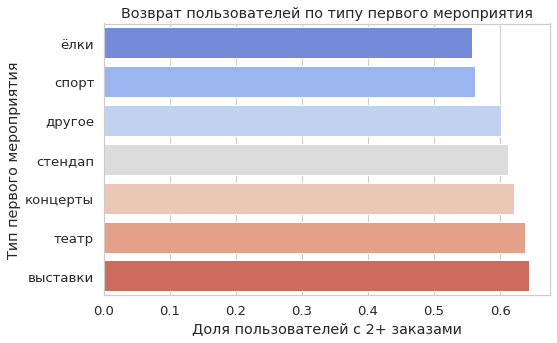

In [97]:
plt.figure(figsize=(8,5))
sns.barplot(x='returned', y='first_event_type', data=event_retention, palette='coolwarm')
plt.xlabel('Доля пользователей с 2+ заказами')
plt.ylabel('Тип первого мероприятия')
plt.title('Возврат пользователей по типу первого мероприятия')
plt.show()

In [98]:
# 2. Доля возвращающихся по типу устройства

In [99]:
device_retention = retention_rate_sorted(user_profile, 'first_device')

In [100]:
device_retention

,first_device,users,returned
1,mobile,18105,0.612041
0,desktop,3743,0.641731


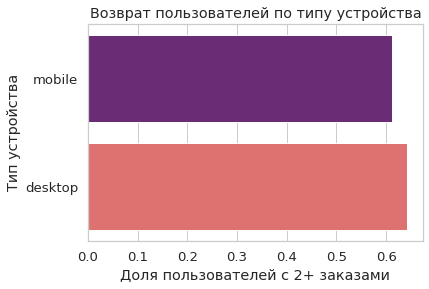

In [101]:
plt.figure(figsize=(6,4))
sns.barplot(x='returned', y='first_device', data=device_retention, palette='magma')
plt.xlabel('Доля пользователей с 2+ заказами')
plt.ylabel('Тип устройства')
plt.title('Возврат пользователей по типу устройства')
plt.show()

In [102]:
# 3. Доля возвращающихся по региону (топ 10 по числу пользователей)

In [103]:
region_retention = retention_rate_sorted(user_profile, 'first_region_name', top_n=10)

In [104]:
region_retention

,first_region_name,users,returned
45,Озернинский край,678,0.554572
41,Малиновоярский округ,529,0.563327
78,Яблоневская область,416,0.598558
74,Травяная область,493,0.618661
23,Каменевский регион,7161,0.627985
52,Речиновская область,446,0.639013
60,Североярская область,3801,0.641410
77,Широковская область,1237,0.649151
57,Светополянский округ,464,0.661638
76,Шанырский регион,503,0.673956


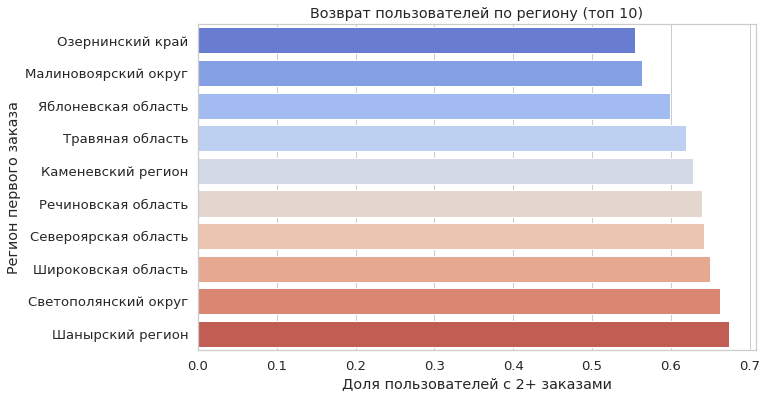

In [105]:
plt.figure(figsize=(10,6))
sns.barplot(x='returned', y='first_region_name', data=region_retention, palette='coolwarm')
plt.xlabel('Доля пользователей с 2+ заказами')
plt.ylabel('Регион первого заказа')
plt.title('Возврат пользователей по региону (топ 10)')
plt.show()

In [106]:
# 4. Доля возвращающихся по билетному оператору (топ 10 по числу пользователей)

In [107]:
service_retention = retention_rate_sorted(user_profile, 'first_service_name', top_n=10)

In [108]:
service_retention

,first_service_name,users,returned
3,билеты без проблем,5223,0.606931
22,мой билет,2981,0.611204
20,лучшие билеты,1188,0.613636
19,лови билет!,2849,0.614602
23,облачко,2196,0.616120
24,прачечная,588,0.629252
4,билеты в руки,2595,0.632370
7,весь в билетах,1304,0.634202
12,дом культуры,358,0.648045
17,край билетов,459,0.655773


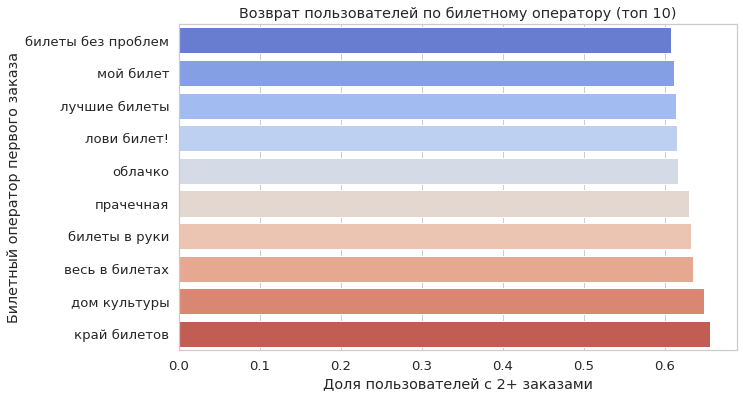

In [109]:
plt.figure(figsize=(10,6))
sns.barplot(x='returned', y='first_service_name', data=service_retention, palette='coolwarm')
plt.xlabel('Доля пользователей с 2+ заказами')
plt.ylabel('Билетный оператор первого заказа')
plt.title('Возврат пользователей по билетному оператору (топ 10)')
plt.show()

Анализ возвратов пользователей по сегментам первого заказа показал, что вероятность совершения второго и последующих заказов зависит от нескольких факторов:

- Тип первого мероприятия: пользователи, начинавшие с театра (64%) или выставок (64%), чаще возвращаются, чем те, кто пришёл на концерты (62%) или стендап (61%). Наименьшая доля возвратов у сегментов «ёлки» (56%) и «спорт» (56%).

- Тип устройства: пользователи с первого заказа на десктопе имеют чуть более высокую вероятность возврата (64%) по сравнению с мобильными пользователями (61%), хотя мобильные устройства остаются основным каналом привлечения (83% пользователей).

- Регион первого заказа: заметна явная дифференциация по регионам. Наибольшая доля возвращающихся в Шанырском регионе (67%), Светополянском округе (66%) и Широковской области (65%), тогда как в Озернинском крае доля возвратов ниже (55%).

- Билетный оператор: пользователи, купившие первый билет через «Край билетов» (66%) и «Дом культуры» (65%), чаще совершают повторные покупки. Наиболее популярные операторы («Билеты без проблем», «Мой билет») показывают возврат около 61-61.5%.

Выводы:

Существуют успешные «точки входа», где пользователи не только приходят на платформу, но и чаще возвращаются: это определённые типы мероприятий (театр, выставки), регионы (Шанырский, Светополянский, Широковская область) и билетные операторы (Край билетов, Дом культуры).

При этом крупные сегменты, например концерты или популярные операторы, имеют большое количество пользователей, но доля возвратов у них чуть ниже среднего.

Эти данные полезны для оптимизации маркетинговых кампаний и удержания пользователей: стоит обращать внимание как на популярные каналы привлечения, так и на сегменты с высокой вероятностью повторного заказа.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [110]:
sports_return = user_profile[user_profile['first_event_type']=='спорт']['is_two'].mean()

In [111]:
concerts_return = user_profile[user_profile['first_event_type']=='концерты']['is_two'].mean()

In [112]:
print(f"Доля возврата для спорта: {sports_return:.2%}")
print(f"Доля возврата для концертов: {concerts_return:.2%}")

Доля возврата для спорта: 56.18%
Доля возврата для концертов: 62.15%


Вывод: пользователи спортивных мероприятий возвращаются реже, чем пользователи концертов. Гипотеза 1 не подтверждается.

In [113]:
region_counts = user_profile.groupby('first_region_name')['user_id'].count().reset_index()

In [114]:
region_counts = region_counts.sort_values('user_id', ascending=False)

In [115]:
top_regions = region_counts.head(5)['first_region_name'].tolist()

In [116]:
less_active_regions = region_counts[region_counts['user_id'] < region_counts['user_id'].median()]['first_region_name'].tolist()

In [117]:
top_return = user_profile[user_profile['first_region_name'].isin(top_regions)]['is_two'].mean()

In [118]:
less_return = user_profile[user_profile['first_region_name'].isin(less_active_regions)]['is_two'].mean()

In [119]:
print(f"Средняя доля возврата в топ-активных регионах: {top_return:.2%}")
print(f"Средняя доля возврата в менее активных регионах: {less_return:.2%}")

Средняя доля возврата в топ-активных регионах: 62.75%
Средняя доля возврата в менее активных регионах: 55.50%


Топ-активные регионы (Каменевский, Североярская область и др.) имеют долю возвратов 62%

Менее активные регионы часто 55%

Вывод: гипотеза 2 частично подтверждается - в более крупных регионах возврат пользователей в целом выше, но эффект умеренный, а некоторые менее активные регионы могут показывать схожие показатели.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [120]:
# Делю пользователей на группы
single_order = user_profile[user_profile['total_orders'] == 1]['avg_revenue']

In [121]:
repeat_order = user_profile[user_profile['total_orders'] >= 2]['avg_revenue']

In [122]:
bins = 30

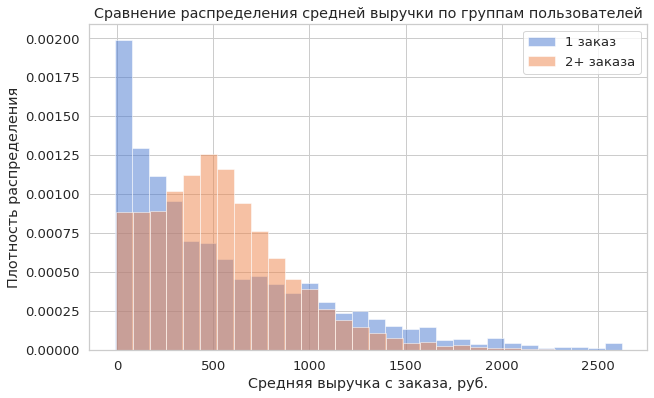

In [123]:
plt.figure(figsize=(10,6))
plt.hist(single_order, bins=bins, alpha=0.5, density=True, label='1 заказ')
plt.hist(repeat_order, bins=bins, alpha=0.5, density=True, label='2+ заказа')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки по группам пользователей')
plt.legend()
plt.show()

Гистограмма наглядно показывает распределение:

Пользователи с одним заказом (синие столбцы) сосредоточены в низких диапазонах средней выручки, большинство заказов до 500-600 руб.

Пользователи с 2 и более заказами (оранжевые столбцы) имеют распределение, сдвинутое вправо, что говорит о более высоких средних тратах на заказ.

Вывод:
Пользователи, совершающие повторные заказы, тратят на один заказ в среднем больше, чем те, кто сделал только один заказ. Это подтверждает связь между размером заказа и вовлечённостью пользователя.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [124]:
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & 
                         (user_profile['total_orders'] <= 4)]['avg_revenue']

In [125]:
group_5_plus = user_profile[user_profile['total_orders'] >= 5]['avg_revenue']

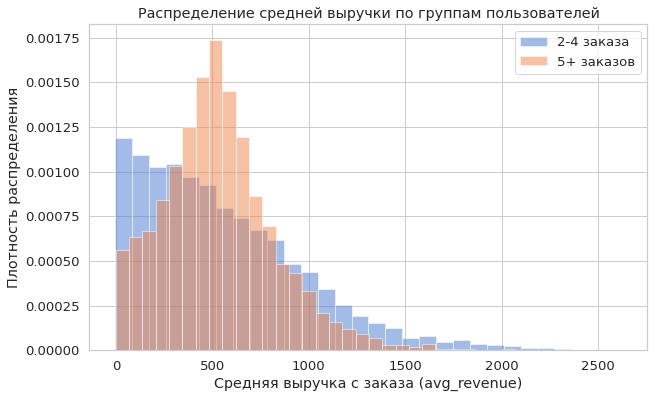

In [126]:
plt.figure(figsize=(10, 6))
bins = 30
plt.hist(group_2_4, bins=bins, alpha=0.5, density=True, label='2-4 заказа')
plt.hist(group_5_plus, bins=bins, alpha=0.5, density=True, label='5+ заказов')
plt.xlabel('Средняя выручка с заказа (avg_revenue)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки по группам пользователей')
plt.legend()
plt.show()

Из гистограмм видно:

У пользователей с 5+ заказами распределение смещено вправо, их средняя выручка с заказа выше, чем у пользователей с 2-4 заказами.

Пик распределения у группы 2-4 заказов находится в диапазоне примерно 300-500 руб.

У группы 5+ заказов пик и большая часть плотности находятся выше, примерно 450-700 руб.

Пользователи, делающие больше заказов, приносят в среднем больше выручки с одного заказа, что подтверждает гипотезу о более ценной лояльной аудитории.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [127]:
bins = [1, 2, 3, 5, user_profile['avg_tickets'].max() + 1]

In [128]:
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']

In [129]:
user_profile['tickets_segment'] = pd.cut(
    user_profile['avg_tickets'],
    bins=bins,
    labels=labels,
    right=False)

In [130]:
segment_stats = (
    user_profile
    .groupby('tickets_segment')
    .agg(
        total_users=('user_id', 'count'),
        repeat_users=('is_two', lambda x: (x == 1).mean())
    ).reset_index())


In [131]:
segment_stats

,tickets_segment,total_users,repeat_users
0,1-2 билета,2421,0.513424
1,2-3 билета,9704,0.741344
2,3-5 билетов,9062,0.543147
3,5+ билетов,661,0.187595


Основные выводы:

- Лучший сегмент «2-3 билета»

Самая высокая доля возвратов: 74%. Это же крупнейший сегмент, т.е. показатель стабилен и достоверен. Значит, пользователи, покупающие небольшие компании / семьями, чаще всего возвращаются.

- Сегменты «1-2 билета» и «3-5 билетов»

Имеют средние показатели возвратов: 51% и 54%. Поведение примерно соответствует общей выборке. 

- Сегмент «5+ билетов» проблемный

Очень низкая доля возвратов: 19%. Пользователи с 5+ билетами редко возвращаются.
Здесь важно учитывать, что сегмент маленький, а значит статистика может быть нестабильной, но всё равно отрыв огромный.

- Возможные причины низких возвратов у 5+ билетов:
    - Корпоративные покупки (редкие, несистемные)

    - Покупки на большие разовые мероприятия (юбилеи, выпускные)

    - Особая категория клиентов, не являющаяся регулярной аудиторией сервиса

Итоговые выводы:

- Распределение пользователей по сегментам неравномерно, больше всего заказов на 2-3 и 3-5 билетов.

- Наиболее лояльная группаЖ покупающие 2-3 билета. Они возвращаются чаще остальных (74%), отличный «точечный вход».

- Сегмент 5+ билетов имеет аномально низкие возвраты (19%). Этот сегмент вероятно состоит из нерегулярных пользователей, значит на него не стоит ориентироваться при оптимизации.

В целом прослеживается тренд:

Маленькие и средние компании (1-5 билетов) возвращаются стабильно

Очень крупные группы - нет

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [132]:
#Добавляю колонку с днем недели первого заказа
user_profile['first_order_weekday'] = user_profile['first_order'].dt.day_name()

In [133]:
user_profile.head()

,user_id,first_order,last_order,first_device,first_region_name,first_service_name,first_event_type,total_orders,avg_revenue,avg_tickets,avg_days_between_orders,is_two,is_five,tickets_segment,first_order_weekday
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0,3-5 билетов,Tuesday
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0,3-5 билетов,Tuesday
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0,2-3 билета,Saturday
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0,3-5 билетов,Thursday
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0,1-2 билета,Sunday


In [134]:
weekday_stats = user_profile.groupby('first_order_weekday').agg(
    total_users=('user_id', 'count'),
    repeat_users=('is_two', 'sum')).reset_index()

In [135]:
weekday_stats['repeat_rate'] = weekday_stats['repeat_users'] / weekday_stats['total_users']

In [136]:
weekday_stats

,first_order_weekday,total_users,repeat_users,repeat_rate
0,Friday,3262,1952,0.598406
1,Monday,2944,1861,0.632133
2,Saturday,3460,2223,0.642486
3,Sunday,2810,1700,0.604982
4,Thursday,3121,1858,0.595322
5,Tuesday,3179,1973,0.620635
6,Wednesday,3072,1916,0.623698


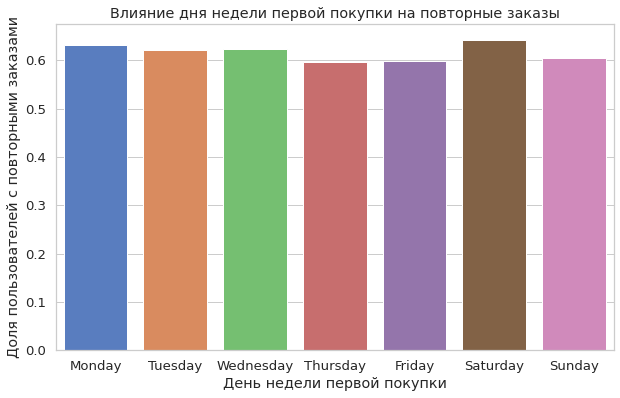

In [137]:
plt.figure(figsize=(10,6))
sns.barplot(data=weekday_stats, x='first_order_weekday', y='repeat_rate',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel('Доля пользователей с повторными заказами')
plt.xlabel('День недели первой покупки')
plt.title('Влияние дня недели первой покупки на повторные заказы')
plt.show()

Выводы:
- Наибольшая доля повторных заказов в Субботу (64.2%).

- Наименьшая доля в Четверг (59.5%).

- Разница между самым высоким и самым низким значением  4.7 п.п..

- День недели первой покупки немного влияет на вероятность повторного заказа.

- Пользователи, которые совершают первый заказ в выходные (особенно в субботу), чуть чаще возвращаются.

- Разница не огромная, но заметная, что может быть полезно для маркетинговых кампаний или планирования акций.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [138]:
def order_group(total_orders):
    if 2 <= total_orders <= 4:
        return '2-4_orders'
    elif total_orders >= 5:
        return '5+_orders'
    else:
        return '1_order'

In [139]:
user_profile['order_group'] = user_profile['total_orders'].apply(order_group)

In [140]:
user_profile.head()

,user_id,first_order,last_order,first_device,first_region_name,first_service_name,first_event_type,total_orders,avg_revenue,avg_tickets,avg_days_between_orders,is_two,is_five,tickets_segment,first_order_weekday,order_group
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0,3-5 билетов,Tuesday,1_order
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0,3-5 билетов,Tuesday,2-4_orders
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0,2-3 билета,Saturday,2-4_orders
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0,3-5 билетов,Thursday,1_order
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0,1-2 билета,Sunday,2-4_orders


In [141]:
group_stats = user_profile[user_profile['total_orders'] > 1].groupby('order_group').agg(
    avg_interval=('avg_days_between_orders', 'mean'),
    user_count=('user_id', 'count')).reset_index()

In [142]:
group_stats

,order_group,avg_interval,user_count
0,2-4_orders,21.407781,7146
1,5+_orders,9.646679,6337


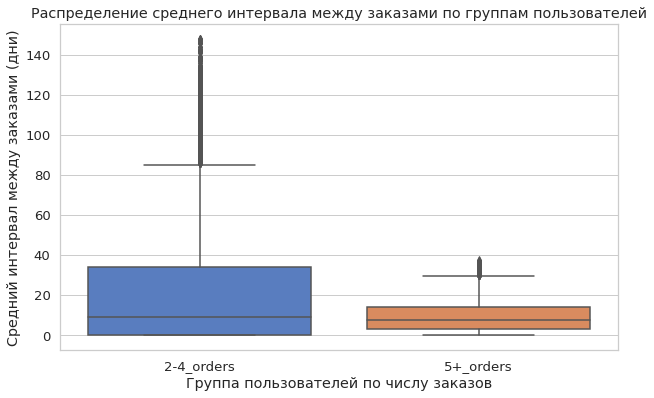

In [143]:
plt.figure(figsize=(10,6))
sns.boxplot(data=user_profile[user_profile['total_orders']>1], x='order_group', y='avg_days_between_orders')
plt.ylabel('Средний интервал между заказами (дни)')
plt.xlabel('Группа пользователей по числу заказов')
plt.title('Распределение среднего интервала между заказами по группам пользователей')
plt.show()

Выводы:
- Пользователи с 5+ заказами делают повторные заказы чаще и быстрее, средний интервал между заказами 10 дней.

- Пользователи с 2-4 заказами имеют более длинный средний интервал  21 день, что говорит о более низкой частоте повторных заказов.

- Чем меньше средний интервал между заказами, тем выше вероятность повторного заказа и удержание клиента.

- Пользователи с коротким интервалом между заказами более лояльные, и их поведение может быть полезно для таргетирования маркетинговых акций.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [144]:
profile_cols = [
    'first_device', 
    'first_region_name', 
    'first_service_name',
    'first_event_type',
    'tickets_segment',
    'first_order_weekday',
    'total_orders'
]

In [145]:
profile_df = user_profile[profile_cols]

In [146]:
corr_matrix = profile_df.phik_matrix(interval_cols=['total_orders'])

In [147]:
corr_matrix

,first_device,first_region_name,first_service_name,first_event_type,tickets_segment,first_order_weekday,total_orders
first_device,1.000000,0.116018,0.081717,0.060991,0.051763,0.073466,0.000000
first_region_name,0.116018,1.000000,0.696886,0.511543,0.146220,0.154284,0.110051
first_service_name,0.081717,0.696886,1.000000,0.587621,0.079955,0.067153,0.101622
first_event_type,0.060991,0.511543,0.587621,1.000000,0.088784,0.084081,0.000000
tickets_segment,0.051763,0.146220,0.079955,0.088784,1.000000,0.026216,0.028789
first_order_weekday,0.073466,0.154284,0.067153,0.084081,0.026216,1.000000,0.055527
total_orders,0.000000,0.110051,0.101622,0.000000,0.028789,0.055527,1.000000


In [148]:
corr_matrix.isna().sum()

first_device           0
first_region_name      0
first_service_name     0
first_event_type       0
tickets_segment        0
first_order_weekday    0
total_orders           0
dtype: int64

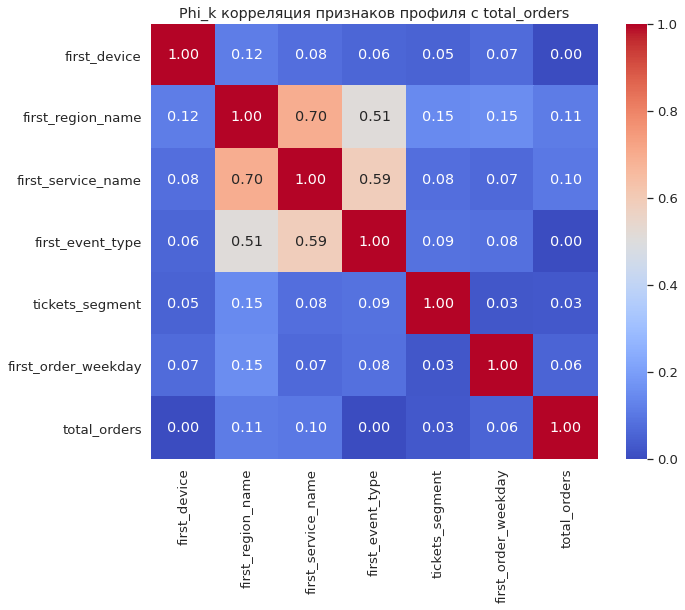

In [149]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Phi_k корреляция признаков профиля с total_orders")
plt.show()

Вывод:
- Сильных корреляций почти нет

- Максимальные значения: first_region_name (0.11) и first_service_name (0.102)

- Остальные признаки почти не связаны с количеством заказов

Причиной может быть то, что в данных большинство пользователей имеют 1 заказ, поэтому разброс total_orders небольшой.

Когда нет вариативности, phi_k не может показать сильную связь.

Для всего датафрейма признаки почти не связаны с количеством заказов. Чтобы увидеть реальные связи, нужно сегментировать пользователей по количеству заказов (1, 2-4, 5+).

In [150]:
seg_name = '5+_orders'

In [151]:
seg_df = user_profile[user_profile['order_group'] == seg_name][profile_cols]

In [152]:
corr_matrix = seg_df.phik_matrix(interval_cols=['total_orders']).fillna(0)

In [153]:
seg_df = user_profile[user_profile['order_group'] == seg][profile_cols]

NameError: name 'seg' is not defined

In [ ]:
corr_matrix = seg_df.phik_matrix(interval_cols=['total_orders']).fillna(0)

In [ ]:
corr_results[seg] = corr_matrix

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title(f"Phi_k корреляция признаков профиля с total_orders ({seg_name})")
plt.show()

выводы:
Сильнее всего связаны с количеством заказов:

- first_region_name - 0.28 (наибольшая связь)

- first_service_name - 0.12 (умеренная связь)

Слабо или почти не связаны:

- first_device, first_event_type, tickets_segment, first_order_weekday


В сегменте активных пользователей (5+_orders) география (first_region_name) больше всего влияет на то, сколько заказов делает человек.

Также имеет небольшое значение первый сервис, который выбрал пользователь.

Остальные признаки практически не оказывают влияния на количество заказов.

In [ ]:
seg_name = '2-4_orders'

In [ ]:
seg_df = user_profile[user_profile['order_group'] == seg_name][profile_cols]

In [ ]:
corr_matrix = seg_df.phik_matrix(interval_cols=['total_orders']).fillna(0)

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title(f"Phi_k корреляция признаков профиля с total_orders ({seg_name})")
plt.show()

Связь в этом сегменте с количеством заказов слабая:

- tickets_segment - 0.076 (немного заметнее)

- first_service_name - 0.064

Остальные признаки почти не влияют (first_device, first_region_name, first_event_type, first_order_weekday)


Возможно причина в том, что разброс total_orders небольшой (только 2, 3, 4), а Phi_k показывает слабую связь, потому что вариативность ограничена

Вывод:

В сегменте пользователей с 2-4 заказами признаки практически не влияют на количество заказов

Реальные сильные влияния появляются только в сегменте активных пользователей (5+_orders)

Общий вывод:
- Я не стала проверять корреляцию для сегмента с 1 заказом, т.к. у всех пользователей этого сегмента total_orders = 1.
Поскольку корреляция (включая phi_k) измеряет связь между изменяющимися величинами, если один столбец константный (нет разброса), то корреляция будет 0 или неопределённой. Любые результаты для этого сегмента будут неинформативными, потому что всё равно получится ноль.

- Сегмент с 2-4 заказами показал слабую связь, практически нет влияния признаков.

- Сегмент с 5+ заказами показал, что реальное влияние оказывают география (first_region_name) и первый сервис (first_service_name).

При работе с удержанием и активностью пользователей стоит ориентироваться на активных клиентов (5+_orders), потому что именно у них признаки профиля реально связаны с количеством заказов.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Выводы по проекту:
1. **Информация о данных**
- Источник данных: заказы пользователей с 06.06.2024 по 31.10.2024.

- Объём: после фильтрации по 99-му перцентилю осталось 13 072 пользователей (из исходных 21 848).

- **Подготовка данных:**

    - Преобразованы даты (order_dt, order_ts) в тип datetime64[ns].

    - Соединены курсы валют: KZT переведён в рубли (revenue_rub) через np.where.

    - Фильтрация выбросов по 99-му перцентилю для total_orders, avg_tickets и avg_days_between_orders.

    - Построен профиль пользователя с ключевыми признаками: дата первого/последнего заказа, устройство, регион, билетный партнёр, жанр мероприятия, общие показатели заказов.

    - Добавлены бинарные признаки: is_two (2+ заказов), is_five (5+ заказов).

- **Проверка качества данных:**

    - Диапазон дат корректный, 153 уникальные даты, пропусков нет.

    - Пики в распределении заказов по дням (5000-7000 заказов) объяснимы сезонностью, акциями, маркетингом.

    - Распределение по часам соответствует стандартному поведению пользователей: пик 11:00-15:00, спад после 17:00, минимальная активность ночью.

2. **Основные результаты анализа**
2.1 **Статистика по пользователям и заказам:**
- Общее число пользователей: 21 848.
- Распределение заказов:
    - Среднее total_orders = 13, медиана = 2 (сильное смещение вправо).

    - После фильтрации 99%: медиана = 4, среднее = 10, максимум = 152.

    - Среднее количество билетов на заказ: 2.75 (медиана = 3).

    - Редкие экстремальные покупки: до 57 билетов (исключены фильтрацией).

    - Среднее время между заказами: среднее 16 дней, медиана 8 дней.

    - После фильтрации экстремальные интервалы сокращены (максимум 112 дней).

- Доля пользователей:

    - Совершивших 2 и более заказов (is_two) - 62%

    - Совершивших 5 и более заказов (is_five) - 29%

2.2 **Распределение пользователей по признакам первого заказа**

- Тип мероприятия: концерты 44%, «другое» 25%, театр 20%, остальные категории <6%.

- Регион проведения: Каменевский 33%, Североярская область 17%, остальные регионы <1%.

- Тип устройства: мобильные 83%, десктоп 17%.

- Билетный оператор: «Билеты без проблем» 24%, «Мой билет» 14%, «Лови билет!» 13%.

Вывод: распределение пользователей явно неравномерное, существуют «точки входа» - сегменты, через которые приходит большинство новых пользователей.

2.3 **Возврат пользователей по сегментам**

- Тип мероприятия: театр и выставки - 64% возвратов; концерты - 62%; спорт и ёлки - 56%.

- Тип устройства: десктоп - 64%, мобильные - 61%.

- Регион: Шанырский 67%, Светополянский 66%, Широковская область 65%, Озернинский край 55%.

- Билетный оператор: «Край билетов» 66%, «Дом культуры» 65%, популярные операторы 61-61.5%.

Вывод: успешные «точки входа» - театры, выставки, определённые регионы и операторы, где пользователи чаще возвращаются.

2.4 **Связь средней выручки и повторных заказов**

- Пользователи с 1 заказом: сосредоточены в диапазоне до 500-600 руб.

- Пользователи с 2+ заказами: распределение сдвинуто вправо, средняя выручка выше.

- Сравнение 2-4 заказа vs 5+ заказов: 5+ заказов - средняя выручка 450-700 руб., 2-4 заказа 300-500 руб.

Вывод: пользователи с большим числом заказов приносят больше выручки и более лояльны.

2.5 **Связь количества билетов с возвратами**

- 2-3 билета: 74% возвратов - крупнейший и стабильный сегмент.

- 1-2 и 3-5 билетов: 51-54% возвратов - средние показатели.

- 5+ билетов: 19% возвратов - аномально низкая лояльность, сегмент мал и нестабилен.

2.6 **Временные характеристики**

- День недели первой покупки: суббота - 64%, четверг - 59,5%.

- Разница 4,7 п.п. - день недели влияет, но умеренно.

- Интервал между заказами: пользователи 5+ заказов - 10 дней, 2-4 заказа - 21 день.

Вывод: чем меньше интервал между заказами, тем выше удержание.

2.7 **Корреляционный анализ phi_k**

- Сегмент 1 заказа: корреляция не информативна (все total_orders = 1).

- Сегмент 2-4 заказа: слабая связь с признаками (phi_k < 0.08).

- Сегмент 5+ заказов:

    - first_region_name - 0.28

    - first_service_name - 0.12

    - Остальные признаки <0.1

Вывод: активные пользователи 5+ заказов зависят от региона и сервиса.

<div style="background-color:#e6f4ff; padding: 15px; border-radius: 8px;">
Дополнила рекомендации для бизнеса

3. **Рекомендации для бизнеса**
    1. **Усилить каналы, которые дают самых лояльных пользователей**

    Анализ показал, что пользователи с высокой вероятностью возврата приходят через определённые «точки входа»:

    - Театр и выставки (64% возвратов)

    - Регионы: Шанырский (67%), Светополянский (66%), Широковская область (65%)

    - Билетные партнёры: «Край билетов», «Дом культуры» (65–66%)

    Рекомендации:

    - Увеличить маркетинговые бюджеты на эти категории и регионы.

    - Развивать партнёрства и эксклюзивные предложения с ведущими операторами.

    - Делать прицельные акции для новых пользователей по этим «точкам входа».

    Ожидаемый эффект: рост доли пользователей, которые возвращаются и продолжают покупать.
    
    2. **Улучшить удержание среди сегмента 1 заказа**
    
    Сегмент с одним заказом огромен, но почти не возвращается, а его средняя выручка низкая.

    Рекомендации:

    - Запустить серии триггерных коммуникаций:

        - через 1-3 дня после покупки: «Посмотрите похожие мероприятия»

        - через 7 дней: персональные рекомендации

        - через 14 дней: промокод на повторную покупку

    - Добавить push/email в момент активации билетов или близко к дате мероприятия.

    - Тестировать «бесплатный апгрейд места» или «сервис-пакет» для новых покупателей.

    Ожидаемый эффект: повышение возврата в ключевом сегменте.
    3. **Фокус на сегменте 2–3 билетов (оптимальная корзина)**

    Этот сегмент самый лояльный (74% возвратов).

    Рекомендации:

    - Делать персональные сегментированные предложения:
        - «Купите 2–3 билета и получите ранний доступ / приоритетный обмен / скидку на следующий заказ»

    - Промотировать групповые мероприятия, семейные активности.

    - В карточке мероприятия показывать блок: «Обычно покупают 2-3 билета».
    
    Ожидаемый эффект: рост среднего чека и возвратов.
    4. **Повышать конверсию среди пользователей с 3-5 и 5+ билетами**

    Сегмент 5+ билетов огромен по чеку, но возвращается только 19%.

    Рекомендации:

    - Ввести специальную программу для организованных групп:

        - раннее бронирование

        - фиксированная цена

        - персональный менеджер

        - приглашение на закрытые мероприятия

    - Предлагать корпоративные пакеты

    Ожидаемый эффект: увеличение выручки и повышение возврата среди высокодоходного сегмента.
    5. **Использовать данные о времени покупки**

    Пик активности: 11:00-15:00, снижение после 17:00.

    Рекомендации:

    - Планировать рекламные кампании на пик активности

    - Вводить «midday deals» - промо, действующие до 15:00

    - Тестировать пуши и e-mail в эти временные слоты

    Ожидаемый эффект: повышение эффективности маркетинга и конверсии.
    6. **Использование корреляций**

    Сегмент 5+ заказов показывает связь поведения с регионом и сервисом.

    Рекомендации:

    - Строить модели прогнозирования LTV/retention с учётом региона

    - Делать отдельные кампании под регионы с высоким и низким retention

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**